# HRRR severe weather prediction verification

**Metrics**

* AUC
* CSI
* BSS

In [1]:
import sys
from glob import glob

import time
import h5py
import zarr
import numpy as np
import pandas as pd

In [2]:
sys.path.insert(0, '/glade/u/home/ksha/NCAR/')
sys.path.insert(0, '/glade/u/home/ksha/NCAR/libs/')

from namelist import *
import data_utils as du

In [3]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

In [4]:
from datetime import datetime, timedelta
from scipy.spatial import cKDTree

In [5]:
from sklearn.metrics import classification_report, auc, roc_curve
from sklearn.metrics import confusion_matrix

In [6]:
with h5py.File(save_dir+'HRRR_domain.hdf', 'r') as h5io:
    lon_72km = h5io['lon_72km'][...]
    lat_72km = h5io['lat_72km'][...]
    lon_3km = h5io['lon_3km'][...]
    lat_3km = h5io['lat_3km'][...]
    land_mask_72km = h5io['land_mask_72km'][...]
    

In [7]:
base_v3_s = datetime(2018, 7, 15)
base_v3_e = datetime(2020, 12, 2)

base_v4_s = datetime(2020, 12, 3)
base_v4_e = datetime(2022, 7, 15)

base_ref = datetime(2010, 1, 1)

date_list_v3 = [base_v3_s + timedelta(days=day) for day in range(365+365+142)]
date_list_v4 = [base_v4_s + timedelta(days=day) for day in range(365+180)]

In [8]:
lead = 21

day_start = 675
day_end = 872
N_days = day_end - day_start

#preserve_inds = [4, 5, 6, 15, 16]
#shape_record = record_v3.shape

In [9]:
N_days

197

In [10]:
batch_dir = '/glade/scratch/ksha/DATA/NCAR_batch/'
temp_dir = '/glade/work/ksha/NCAR/Keras_models/'

final_out1 = zarr.load(temp_dir+'CONVNEXT_L_pp10_tune3'+'_lead{}_prob.zarr'.format(21))
#final_out2 = zarr.load(temp_dir+'NEW_S_pp19_tune3'+'_lead{}_prob.zarr'.format(21))
final_out = final_out1#+ 0.5*final_out2

In [11]:
Y_pred_grid = np.copy(final_out)
#Y_pred_grid[:, ~land_mask_72km] = np.nan 
Y_pred_point = Y_pred_grid[:, land_mask_72km]

In [12]:
# def neighbour_leads(lead):
#     out = [lead-2, lead-1, lead, lead+1]
#     flag_shift = [0, 0, 0, 0]
    
#     for i in range(4):
#         if out[i] < 0:
#             out[i] = 24+out[i]
#             flag_shift[i] = -1
#         if out[i] > 23:
#             out[i] = out[i]-24
#             flag_shift[i] = +1
            
#     return out, flag_shift

# lead_window, flag_shift = neighbour_leads(lead)

# record_all = ()

# for i, lead_temp in enumerate(lead_window):
    
#     flag_ = flag_shift[i]
    
#     with h5py.File(save_dir_scratch+'SPC_all_lead{}.hdf'.format(lead_temp), 'r') as h5io:
#         record_temp = h5io['record_v3'][...]
        
#     if flag_shift[i] == 0:
#         record_all = record_all + (record_temp,)
        
#     if flag_shift[i] == -1:
#         record_temp[1:, ...] = record_temp[:-1, ...]
#         record_temp[0, ...] = np.nan
#         record_all = record_all + (record_temp,)
    
#     if flag_shift[i] == +1:
#         record_temp[:-1, ...] = record_temp[1:, ...]
#         record_temp[-1, ...] = np.nan
#         record_all = record_all + (record_temp,)


# shape_record = record_temp.shape      

# record_v3 = np.concatenate(record_all, axis=1)
# record_v3 = record_v3[day_start:day_end, :]

# record_shape = record_v3.shape

# gridTree = cKDTree(list(zip(lon_72km.ravel(), lat_72km.ravel())))
# grid_shape = lon_72km.shape

# for f in range(int(record_shape[-1]/2)):
#     for i in range(N_days):
        
#         lon_temp = record_v3[i, 2*f]
#         lat_temp = record_v3[i, 2*f+1]
        
#         flag_obs = lon_temp + lat_temp

#         if np.logical_not(np.isnan(flag_obs)):
            
#             dist, indexes = gridTree.query(list(zip(lon_temp[None], lat_temp[None])))
#             indx_72km, indy_72km = np.unravel_index(indexes, grid_shape)
#             indx_72km = indx_72km[0]
#             indy_72km = indy_72km[0]
            
#             Y_pred_grid

In [13]:
with h5py.File(save_dir_scratch+'SPC_to_lead{}_72km_all.hdf'.format(lead-2), 'r') as h5io:
    record_1 = h5io['record_v3'][...]
    
with h5py.File(save_dir_scratch+'SPC_to_lead{}_72km_all.hdf'.format(lead-1), 'r') as h5io:
    record_2 = h5io['record_v3'][...]
    
with h5py.File(save_dir_scratch+'SPC_to_lead{}_72km_all.hdf'.format(lead), 'r') as h5io:
    record_3 = h5io['record_v3'][...]
    
with h5py.File(save_dir_scratch+'SPC_to_lead{}_72km_all.hdf'.format(lead+1), 'r') as h5io:
    record_4 = h5io['record_v3'][...]
    
record_1[np.isnan(record_1)] = 0
record_2[np.isnan(record_2)] = 0
record_3[np.isnan(record_3)] = 0
record_4[np.isnan(record_4)] = 0

record_v3 = record_1 + record_2 + record_3 + record_4

record_v3[record_v3>1] = 1

In [14]:
Y_true_point = record_v3[:, land_mask_72km]
Y_true_point = np.max(Y_true_point[day_start:day_end, :], axis=-1)

In [15]:
Y_true_point.shape

(197, 1544)

In [16]:
Y_pred_point.shape

(197, 1544)

In [17]:
print('observations:\nTrue (severe weather): {}\nFalse (no severe weather): {}'.format(np.sum(Y_true_point==1), np.sum(Y_true_point==0)))

observations:
True (severe weather): 2737
False (no severe weather): 301431


In [18]:
print(classification_report(Y_pred_point.ravel() > 0.5, Y_true_point.ravel()))

              precision    recall  f1-score   support

       False       0.99      0.99      0.99    301871
        True       0.11      0.13      0.12      2297

    accuracy                           0.99    304168
   macro avg       0.55      0.56      0.56    304168
weighted avg       0.99      0.99      0.99    304168



In [20]:
fpr, tpr, thres = roc_curve(Y_true_point.ravel(), Y_pred_point.ravel())

In [21]:
auc(fpr, tpr)

0.6117863395064317

In [23]:
thress=[0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65]

In [24]:
CSI = []
POFD = []
AUC = []
freq = []

for i, thres in enumerate(thress):

    Y_pred_label = Y_pred_point > thres
    
    tn, fp, fn, tp = confusion_matrix(Y_true_point.ravel(), Y_pred_label.ravel()).ravel()
    CSI.append(tp/(tp+fn+fp))
    POFD.append(fp/(tn+fp))
    freq.append((tp+fp)/(tp+fn))
    

Text(0, 0.5, 'AUC')

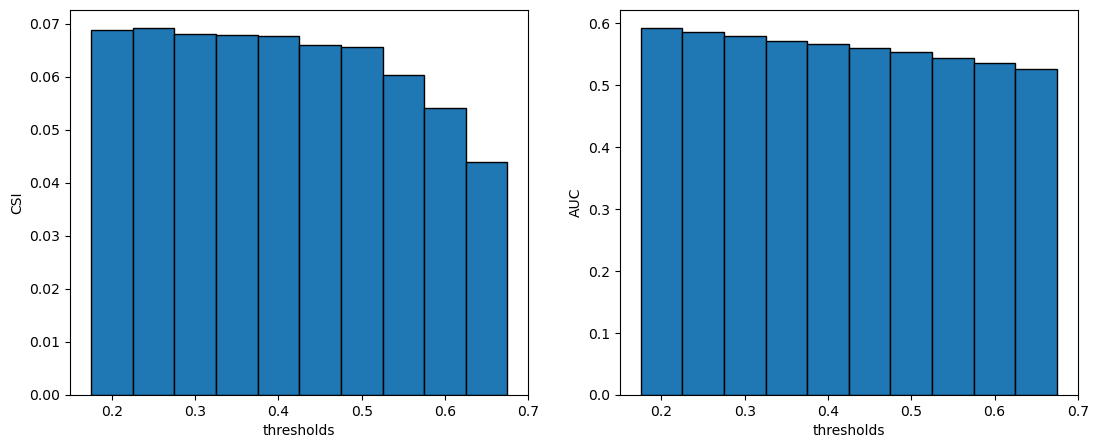

In [25]:
plt.figure(figsize=(13, 5))
plt.subplot(121)
plt.bar(thress, CSI, width=0.05, edgecolor='k')
plt.xlabel('thresholds')
plt.ylabel('CSI')

plt.subplot(122)
plt.bar(thress, AUC, width=0.05, edgecolor='k')
plt.xlabel('thresholds')
plt.ylabel('AUC')

In [26]:
print('CSI: {};\nPOFD: {};\nAUC: {};\nfreq: {}'.format(CSI, POFD, AUC, freq))

CSI: [0.06875391358797746, 0.06915685478413859, 0.06795547744581136, 0.06783194355355997, 0.06762438682550806, 0.06602687140115163, 0.06562235393734124, 0.060338659670880035, 0.05412719891745602, 0.04391891891891892];
POFD: [0.017410286267835758, 0.015433051013333069, 0.013571928567400167, 0.011607963348162598, 0.009856318693166928, 0.008204199302659646, 0.006591890017947723, 0.004830292836503213, 0.0031781734459959327, 0.0017217870756491536];
AUC: [0.5915871476954573, 0.5856338581250471, 0.5779783762351162, 0.5714704063419946, 0.5655870032401904, 0.5587404286643443, 0.5533354031824765, 0.5438033409767065, 0.5349472669489056, 0.5252625993375865];
freq: [2.1180124223602483, 1.88637194008038, 1.6642309097552064, 1.432955791012057, 1.226525392765802, 1.0292290829375228, 0.8392400438436244, 0.6244062842528316, 0.42309097552064306, 0.24187066130800147]


In [23]:
#plt.pcolormesh(Y_pred_grid[3, ...], vmin=0, vmax=1.0, cmap=plt.cm.nipy_spectral_r)

### BSS

In [27]:
from sklearn.metrics import brier_score_loss

In [28]:
def reliability_diagram(cate_true, prob_model, bins):
    binids = np.searchsorted(bins, prob_model)
    bin_sums = np.bincount(binids, weights=prob_model, minlength=len(bins))
    bin_true = np.bincount(binids, weights=cate_true, minlength=len(bins))
    bin_total = np.bincount(binids, minlength=len(bins))
    flag = bin_total > 0
    prob_true = bin_true/bin_total
    prob_pred = bin_sums/bin_total
    prob_true[~flag] = np.nan
    return prob_true, prob_pred

In [29]:
N_bins = 15
hist_bins = np.linspace(0, 1, N_bins)
N_boost = 100

In [30]:
prob_true_, prob_pred_ = reliability_diagram(Y_true_point.ravel(), Y_pred_point.ravel(), hist_bins)
brier_score_loss(Y_true_point.ravel(), Y_pred_point.ravel())

/glade/scratch/ksha/ipykernel_185970/2772493973.py:7: RuntimeWarning: invalid value encountered in divide
  prob_true = bin_true/bin_total
/glade/scratch/ksha/ipykernel_185970/2772493973.py:8: RuntimeWarning: invalid value encountered in divide
  prob_pred = bin_sums/bin_total


0.011489001669823893

In [31]:
brier_score_loss(Y_true_point.ravel(), 0.0089983*np.ones(Y_true_point.ravel().shape))

0.00891734701591964

In [264]:
#brier[d, n] = brier_
#hist_bins_ = np.mean(prob_pred[d, ...], axis=1)
#use_, _ = np.histogram(fcst, bins=np.array(list(hist_bins_)+[1.0]))
#use[d, :] = use_

In [33]:
o_bar_ = np.mean(Y_true_point.ravel())

In [34]:
from sklearn.calibration import calibration_curve

In [38]:
prob_true, prob_pred = calibration_curve(Y_true_point.ravel(), Y_pred_point.ravel(), n_bins=50)

(0.0, 1.0)

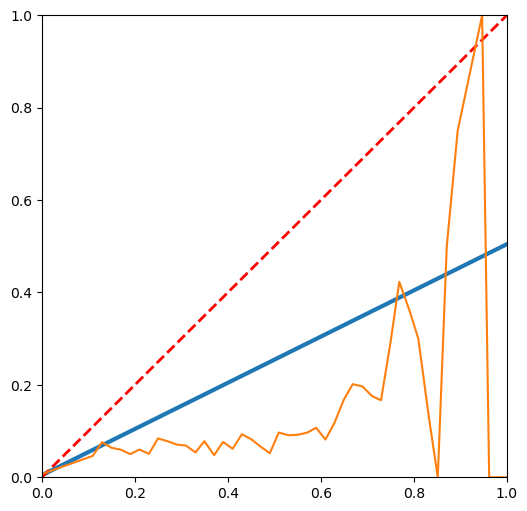

In [39]:
fig = plt.figure(figsize=(6, 6))
ax = fig.gca()


ax.plot(prob_pred, 0.5*prob_pred + 0.5*o_bar_, lw=3.0)

ax.plot(np.linspace(0, 1, 10), np.linspace(0, 1, 10), 'r--', lw=2.0)

plt.plot(prob_pred, prob_true)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

In [40]:
0.011489001669823893 / 0.00891734701591964

1.288387863488235